In [ ]:
!git clone https://github.com/Rene-Capistran/UTRGV-Capstone-2025

Cloning into 'UTRGV-Capstone-2025'...
remote: Enumerating objects: 2760, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 2760 (delta 54), reused 119 (delta 26), pack-reused 2526 (from 2)
Receiving objects: 100% (2760/2760), 1.47 GiB | 14.04 MiB/s, done.
Resolving deltas: 100% (2112/2112), done.
Filtering content: 100% (19/19), 815.07 MiB | 45.55 MiB/s, done.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# ==============================
# STEP 1: LOAD AND COMBINE DATA
# ==============================
file_map = {
    'ArduinoNano': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv'
        ]
    },
    'ArduinoUno': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv'
        ]
    },
    'ESP32': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/ESP_32_9600_dataset.csv'
        ]
    },
    'RaspberryPi5': {
        'UART': [
            '/content/UTRGV-Capstone-2025/Data/Processed/RPi_5B_9600_dataset.csv'
        ]
    }
}

files = []
print("Files to process:")
for device, protocols in file_map.items():
    for protocol, file_list in protocols.items():
        for file in file_list:
            print(f"  - {file}")
            files.append(file)

all_data = []
for file in files:
    print(f"\nLoading {file}...")
    df = pd.read_csv(file)
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")
    print(f"  First few rows:")
    print(df.head(3))

    # Identify device family from file path
    if "UNO" in file.upper():
        device_family = "ArduinoUno"
    elif "NANO" in file.upper():
        device_family = "ArduinoNano"
    elif "ESP" in file.upper():
        device_family = "ESP32"
    elif "RPI" in file.upper():
        device_family = "RaspberryPi5"
    else:
        device_family = "Unknown"

    # Add Device_Family column (for confusion matrix - 4 classes)
    df['Device_Family'] = device_family

    # Create Full_Label (for detailed metrics - all device+label combinations)
    if 'label' in df.columns:
        df['Full_Label'] = df['Device_Family'] + "_" + df['label'].astype(str)
    else:
        df['label'] = 0
        df['Full_Label'] = df['Device_Family'] + "_0"

    all_data.append(df)
    print(f"  Added {len(df)} rows for {device_family}")

# Combine all devices
combined_df = pd.concat(all_data, ignore_index=True)
combined_df.to_csv("Combined_Device_Data.csv", index=False)
print("\n" + "="*50)
print("Combined dataset shape:", combined_df.shape)
print("Device distribution (4 families):")
print(combined_df['Device_Family'].value_counts())
print("\nDetailed label distribution (all combinations):")
print(combined_df['Full_Label'].value_counts())
print("="*50)

Files to process:
  - /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/ESP_32_9600_dataset.csv
  - /content/UTRGV-Capstone-2025/Data/Processed/RPi_5B_9600_dataset.csv

Loading /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv...
  Shape: (300, 23)
  Columns: ['mean_one', 'std_one', 'std_zero', 'var_one', 'var_zero', 'skew_one', 'skew_zero', 'kurt_one', 'kurt_zero', 'rms_one', 'rms_zero', 'en_one', 'en_zero', 'max_one', 'max_zero', 'min_one', 'min_zero', 'mse_one', 'cos_one', 'cos_zero', 'msg_size', 'char_len', 'label']
  First few rows:
   mean_one   std_one  std_zero   var_one  var_zero   skew_one  skew_zero  \
0  4.363303  0.021344  1.872673  0.000456  3.506903   0.508805  -1.769614   
1  4.390236  0.007868  0.433973  0.000062  0.188332 -57.934636 -11.343618   
2  4.651824  0.012953  0.010991  0.000168  0.000121 

In [ ]:
# ==============================
# STEP 2: PREPARE FEATURES AND TARGET
# ==============================
# NOTE: The input CSVs already contain extracted features (mean_one, std_one, etc.)
# for each sample/window. We will use these rows directly instead of aggregating them.

features_df = combined_df.copy()

# Use numeric columns as features, excluding labels and metadata
exclude_cols = ['Device_Family', 'Full_Label', 'label', 'msg_size']
feature_cols = [col for col in features_df.columns
                if features_df[col].dtype in [np.float64, np.int64]
                and col not in exclude_cols]

print(f"\nUsing {len(feature_cols)} features for training")
print(f"Feature columns: {feature_cols}")

X = features_df[feature_cols]
y_full = features_df['Full_Label']  # Detailed labels (device + label)
y_family = features_df['Device_Family']  # Family labels only

# Handle NaN values
initial_rows = len(X)
X = X.fillna(0)  # Fill NaN with 0 instead of dropping
print(f"Filled {X.isna().sum().sum()} NaN values with 0.")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le_full = LabelEncoder()
y_full_encoded = le_full.fit_transform(y_full)

le_family = LabelEncoder()
y_family_encoded = le_family.fit_transform(y_family)

print(f"\nFinal dataset shape: {X_scaled.shape}")
print(f"Number of detailed classes: {len(le_full.classes_)}")
print(f"Detailed classes: {le_full.classes_}")
print(f"Number of device families: {len(le_family.classes_)}")
print(f"Device families: {le_family.classes_}")



Using 21 features for training
Feature columns: ['mean_one', 'std_one', 'std_zero', 'var_one', 'var_zero', 'skew_one', 'skew_zero', 'kurt_one', 'kurt_zero', 'rms_one', 'rms_zero', 'en_one', 'en_zero', 'max_one', 'max_zero', 'min_one', 'min_zero', 'mse_one', 'cos_one', 'cos_zero', 'char_len']
Filled 0 NaN values with 0.

Final dataset shape: (1211, 21)
Number of detailed classes: 18
Detailed classes: ['ArduinoNano_A' 'ArduinoNano_B' 'ArduinoUno_A' 'ArduinoUno_B'
 'ArduinoUno_C' 'ArduinoUno_D' 'ArduinoUno_E' 'ArduinoUno_F'
 'ArduinoUno_G' 'ESP32_A' 'ESP32_B' 'ESP32_C' 'ESP32_D' 'ESP32_E'
 'ESP32_F' 'ESP32_G' 'RaspberryPi5_A' 'RaspberryPi5_B']
Number of device families: 4
Device families: ['ArduinoNano' 'ArduinoUno' 'ESP32' 'RaspberryPi5']


In [ ]:
# ==============================
# STEP 3: TRAIN/TEST SPLIT
# ==============================
X_train, X_val, y_train_full, y_val_full, y_train_family, y_val_family = train_test_split(
    X_scaled, y_full_encoded, y_family_encoded,
    test_size=0.2,
    stratify=y_full_encoded,
    random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 968
Validation set size: 243


In [ ]:
# ==============================
# STEP 4: TRAIN MODELS
# ==============================
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

trained_models = {}
results = []
all_predictions = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)
    model.fit(X_train, y_train_full)
    y_pred = model.predict(X_val)

    all_predictions.append(y_pred)
    accuracy = np.mean(y_pred == y_val_full)
    results.append((name, accuracy))
    trained_models[name] = model

    print(f"{name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Summary
print("\n" + "="*50)
print("MODEL ACCURACY SUMMARY (DETAILED LABELS)")
print("="*50)
for name, acc in results:
    print(f"{name:25s}: {acc:.4f} ({acc*100:.2f}%)")



Training RandomForest...
RandomForest Accuracy: 0.8519 (85.19%)

Training SVM...
SVM Accuracy: 0.6049 (60.49%)

Training KNN...
KNN Accuracy: 0.6831 (68.31%)

Training LogisticRegression...
LogisticRegression Accuracy: 0.5926 (59.26%)

Training XGBoost...
XGBoost Accuracy: 0.8642 (86.42%)

MODEL ACCURACY SUMMARY (DETAILED LABELS)
RandomForest             : 0.8519 (85.19%)
SVM                      : 0.6049 (60.49%)
KNN                      : 0.6831 (68.31%)
LogisticRegression       : 0.5926 (59.26%)
XGBoost                  : 0.8642 (86.42%)



INDIVIDUAL MODEL CLASSIFICATION REPORTS

RandomForest - DETAILED CLASSIFICATION REPORT

RandomForest Accuracy: 0.8519 (85.19%)

RandomForest Classification Report (All Detailed Labels):
                precision    recall  f1-score   support

 ArduinoNano_A       1.00      1.00      1.00        30
 ArduinoNano_B       1.00      1.00      1.00        30
  ArduinoUno_A       0.88      0.70      0.78        10
  ArduinoUno_B       0.70      0.78      0.74         9
  ArduinoUno_C       0.80      0.44      0.57         9
  ArduinoUno_D       0.67      0.89      0.76         9
  ArduinoUno_E       0.55      0.67      0.60         9
  ArduinoUno_F       0.83      0.56      0.67         9
  ArduinoUno_G       0.25      0.33      0.29         9
       ESP32_A       1.00      1.00      1.00        10
       ESP32_B       0.75      0.33      0.46         9
       ESP32_C       1.00      0.89      0.94         9
       ESP32_D       1.00      0.67      0.80         9
       ESP32_E       0.89   

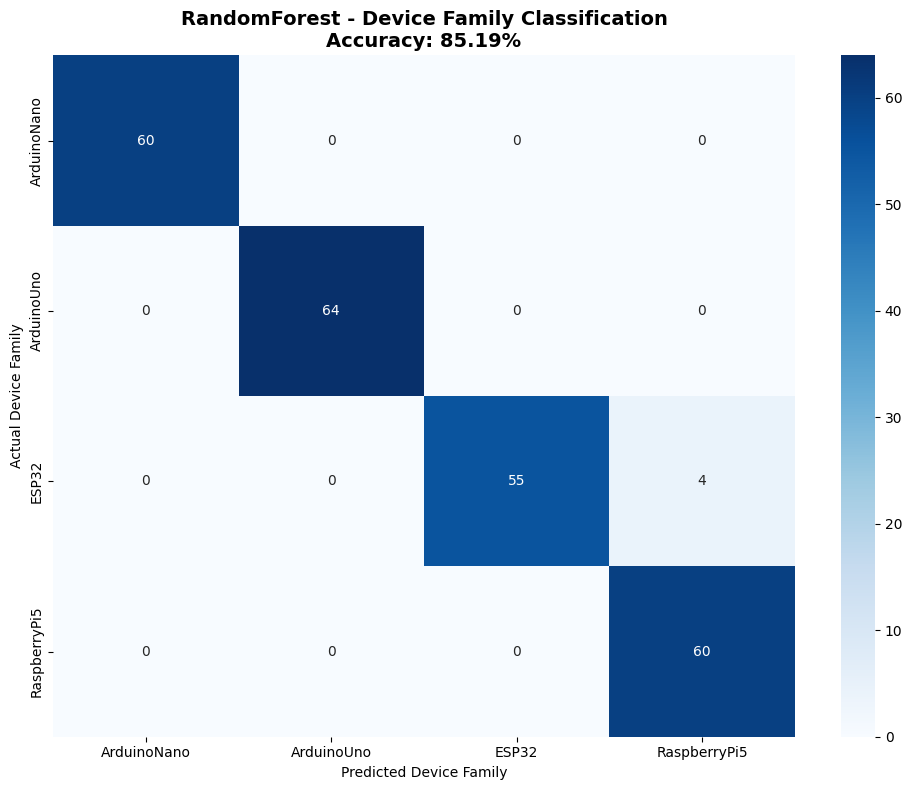


SVM - DETAILED CLASSIFICATION REPORT

SVM Accuracy: 0.6049 (60.49%)

SVM Classification Report (All Detailed Labels):
                precision    recall  f1-score   support

 ArduinoNano_A       0.94      0.97      0.95        30
 ArduinoNano_B       1.00      0.93      0.97        30
  ArduinoUno_A       0.44      0.70      0.54        10
  ArduinoUno_B       0.17      0.11      0.13         9
  ArduinoUno_C       0.60      0.33      0.43         9
  ArduinoUno_D       0.50      0.56      0.53         9
  ArduinoUno_E       0.38      0.56      0.45         9
  ArduinoUno_F       0.00      0.00      0.00         9
  ArduinoUno_G       0.21      0.33      0.26         9
       ESP32_A       1.00      0.20      0.33        10
       ESP32_B       0.30      0.67      0.41         9
       ESP32_C       1.00      0.56      0.71         9
       ESP32_D       0.44      0.78      0.56         9
       ESP32_E       1.00      0.33      0.50         9
       ESP32_F       0.80      0.40     

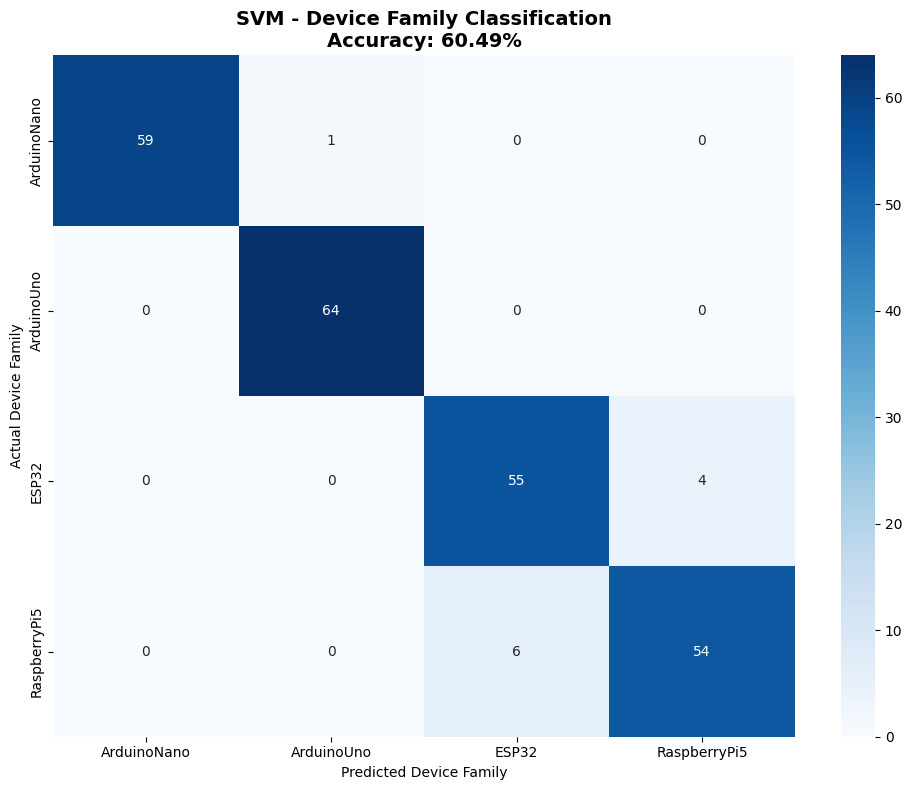


KNN - DETAILED CLASSIFICATION REPORT

KNN Accuracy: 0.6831 (68.31%)

KNN Classification Report (All Detailed Labels):
                precision    recall  f1-score   support

 ArduinoNano_A       0.93      0.90      0.92        30
 ArduinoNano_B       0.88      0.93      0.90        30
  ArduinoUno_A       0.37      0.70      0.48        10
  ArduinoUno_B       0.33      0.44      0.38         9
  ArduinoUno_C       0.57      0.44      0.50         9
  ArduinoUno_D       0.22      0.22      0.22         9
  ArduinoUno_E       0.29      0.22      0.25         9
  ArduinoUno_F       0.20      0.11      0.14         9
  ArduinoUno_G       0.50      0.22      0.31         9
       ESP32_A       0.83      1.00      0.91        10
       ESP32_B       0.25      0.22      0.24         9
       ESP32_C       1.00      0.67      0.80         9
       ESP32_D       0.86      0.67      0.75         9
       ESP32_E       0.82      1.00      0.90         9
       ESP32_F       0.70      0.70     

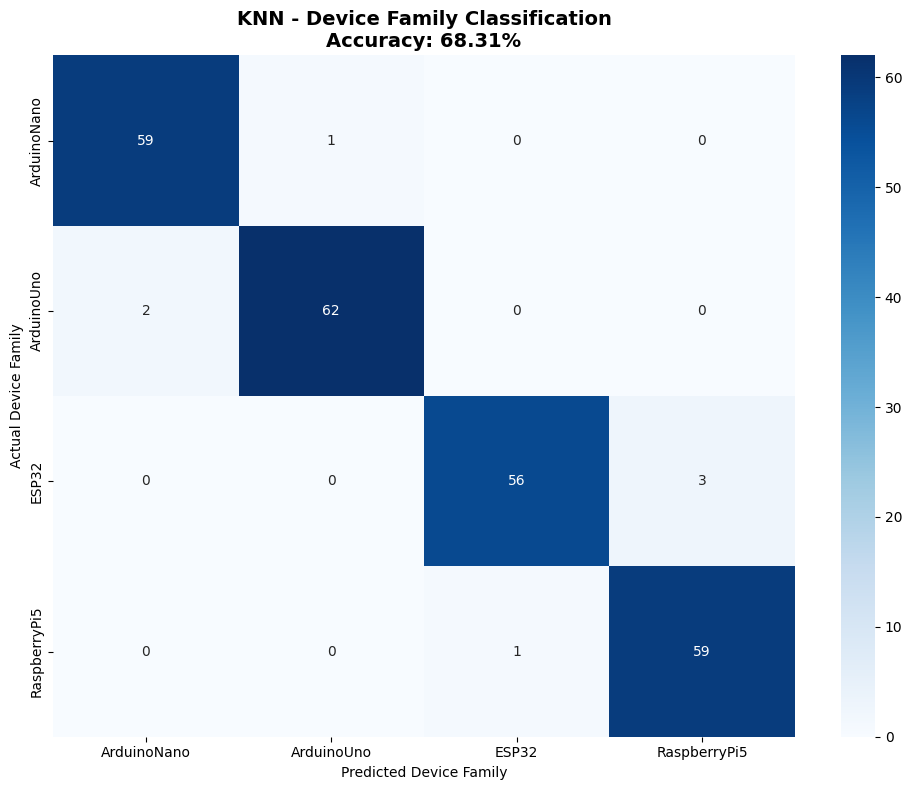


LogisticRegression - DETAILED CLASSIFICATION REPORT

LogisticRegression Accuracy: 0.5926 (59.26%)

LogisticRegression Classification Report (All Detailed Labels):
                precision    recall  f1-score   support

 ArduinoNano_A       0.97      0.93      0.95        30
 ArduinoNano_B       0.97      0.97      0.97        30
  ArduinoUno_A       0.41      0.70      0.52        10
  ArduinoUno_B       0.50      0.22      0.31         9
  ArduinoUno_C       0.29      0.22      0.25         9
  ArduinoUno_D       0.60      0.33      0.43         9
  ArduinoUno_E       0.30      0.33      0.32         9
  ArduinoUno_F       0.27      0.33      0.30         9
  ArduinoUno_G       0.22      0.22      0.22         9
       ESP32_A       1.00      0.20      0.33        10
       ESP32_B       0.12      0.11      0.12         9
       ESP32_C       0.31      0.44      0.36         9
       ESP32_D       0.33      0.78      0.47         9
       ESP32_E       1.00      0.33      0.50      

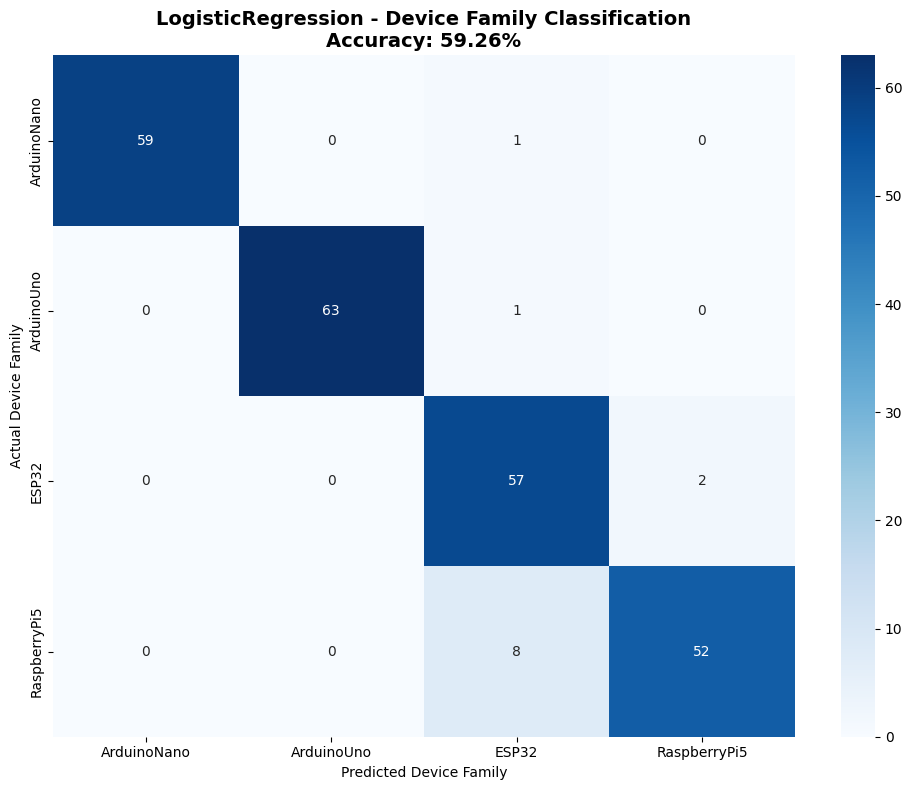


XGBoost - DETAILED CLASSIFICATION REPORT

XGBoost Accuracy: 0.8642 (86.42%)

XGBoost Classification Report (All Detailed Labels):
                precision    recall  f1-score   support

 ArduinoNano_A       1.00      0.93      0.97        30
 ArduinoNano_B       0.94      1.00      0.97        30
  ArduinoUno_A       0.90      0.90      0.90        10
  ArduinoUno_B       0.78      0.78      0.78         9
  ArduinoUno_C       0.83      0.56      0.67         9
  ArduinoUno_D       0.75      1.00      0.86         9
  ArduinoUno_E       0.67      0.44      0.53         9
  ArduinoUno_F       1.00      0.56      0.71         9
  ArduinoUno_G       0.38      0.67      0.48         9
       ESP32_A       1.00      1.00      1.00        10
       ESP32_B       0.57      0.44      0.50         9
       ESP32_C       0.88      0.78      0.82         9
       ESP32_D       0.88      0.78      0.82         9
       ESP32_E       0.89      0.89      0.89         9
       ESP32_F       0.73   

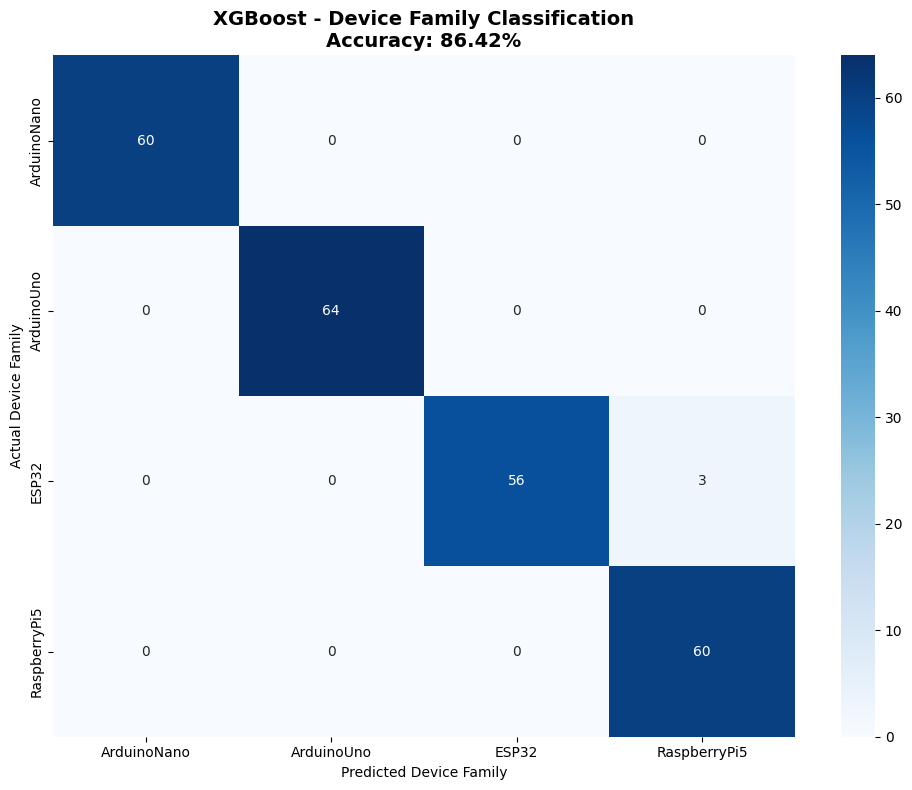


MODEL ACCURACY SUMMARY (DETAILED LABELS)
RandomForest             : 0.8519 (85.19%)
SVM                      : 0.6049 (60.49%)
KNN                      : 0.6831 (68.31%)
LogisticRegression       : 0.5926 (59.26%)
XGBoost                  : 0.8642 (86.42%)

ALL INDIVIDUAL MODEL REPORTS COMPLETE


In [31]:
# ==============================
# STEP 5: INDIVIDUAL MODEL PREDICTIONS & REPORTS
# ==============================
print("\n" + "="*70)
print("INDIVIDUAL MODEL CLASSIFICATION REPORTS")
print("="*70)

# Store all predictions for later use
all_model_predictions = []

for name, model in trained_models.items():
    print(f"\n{'='*70}")
    print(f"{name} - DETAILED CLASSIFICATION REPORT")
    print('='*70)

    # Get predictions for this specific model
    y_pred = model.predict(X_val)
    all_model_predictions.append(y_pred)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_val_full)
    print(f"\n{name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Decode predictions
    y_pred_decoded = le_full.inverse_transform(y_pred)
    y_val_full_decoded = le_full.inverse_transform(y_val_full)

    # Classification report for this model
    print(f"\n{name} Classification Report (All Detailed Labels):")
    print(classification_report(y_val_full_decoded, y_pred_decoded, zero_division=0))

    # Optional: Confusion matrix for each model
    print(f"\n{name} - Confusion Matrix (Device Families):")
    y_pred_family = [get_device_family(label) for label in y_pred_decoded]
    y_val_family_decoded = [get_device_family(label) for label in y_val_full_decoded]

    family_labels = ['ArduinoNano', 'ArduinoUno', 'ESP32', 'RaspberryPi5']
    cm_family = confusion_matrix(y_val_family_decoded, y_pred_family, labels=family_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_family, annot=True, fmt='d', cmap='Blues',
                xticklabels=family_labels, yticklabels=family_labels)
    plt.title(f'{name} - Device Family Classification\nAccuracy: {accuracy*100:.2f}%',
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Device Family')
    plt.ylabel('Actual Device Family')
    plt.tight_layout()
    plt.show()

# Summary table
print("\n" + "="*70)
print("MODEL ACCURACY SUMMARY (DETAILED LABELS)")
print("="*70)
for name, acc in results:
    print(f"{name:25s}: {acc:.4f} ({acc*100:.2f}%)")

print("\n" + "="*70)
print("ALL INDIVIDUAL MODEL REPORTS COMPLETE")
print("="*70)


CONFUSION MATRIX 1: DEVICE FAMILIES


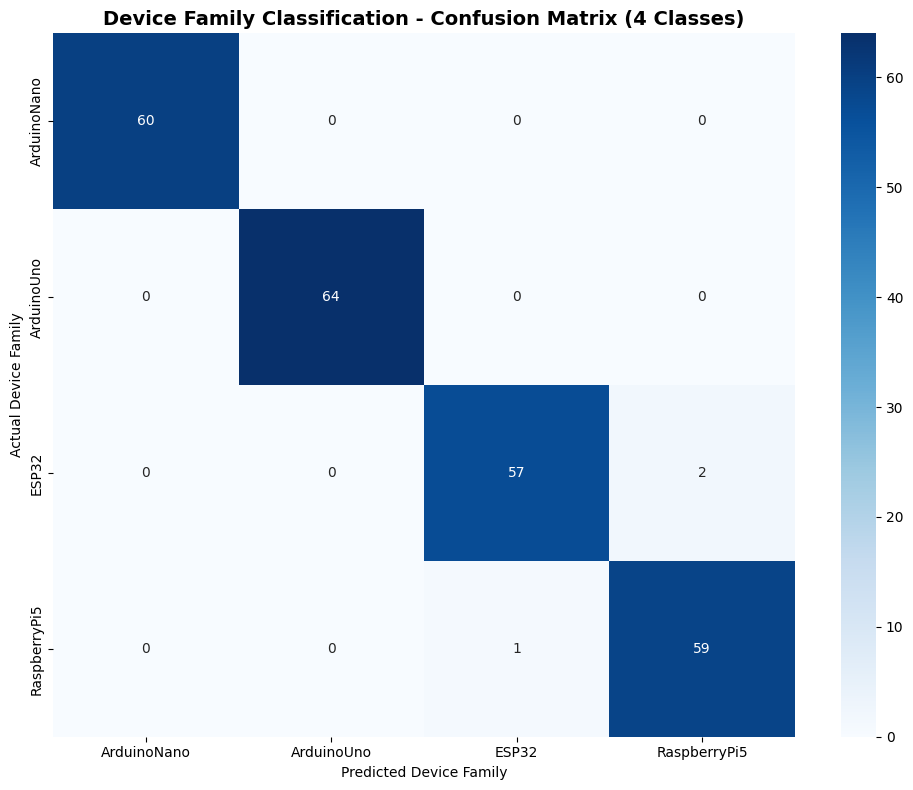


CONFUSION MATRIX 2: ALL DETAILED LABELS


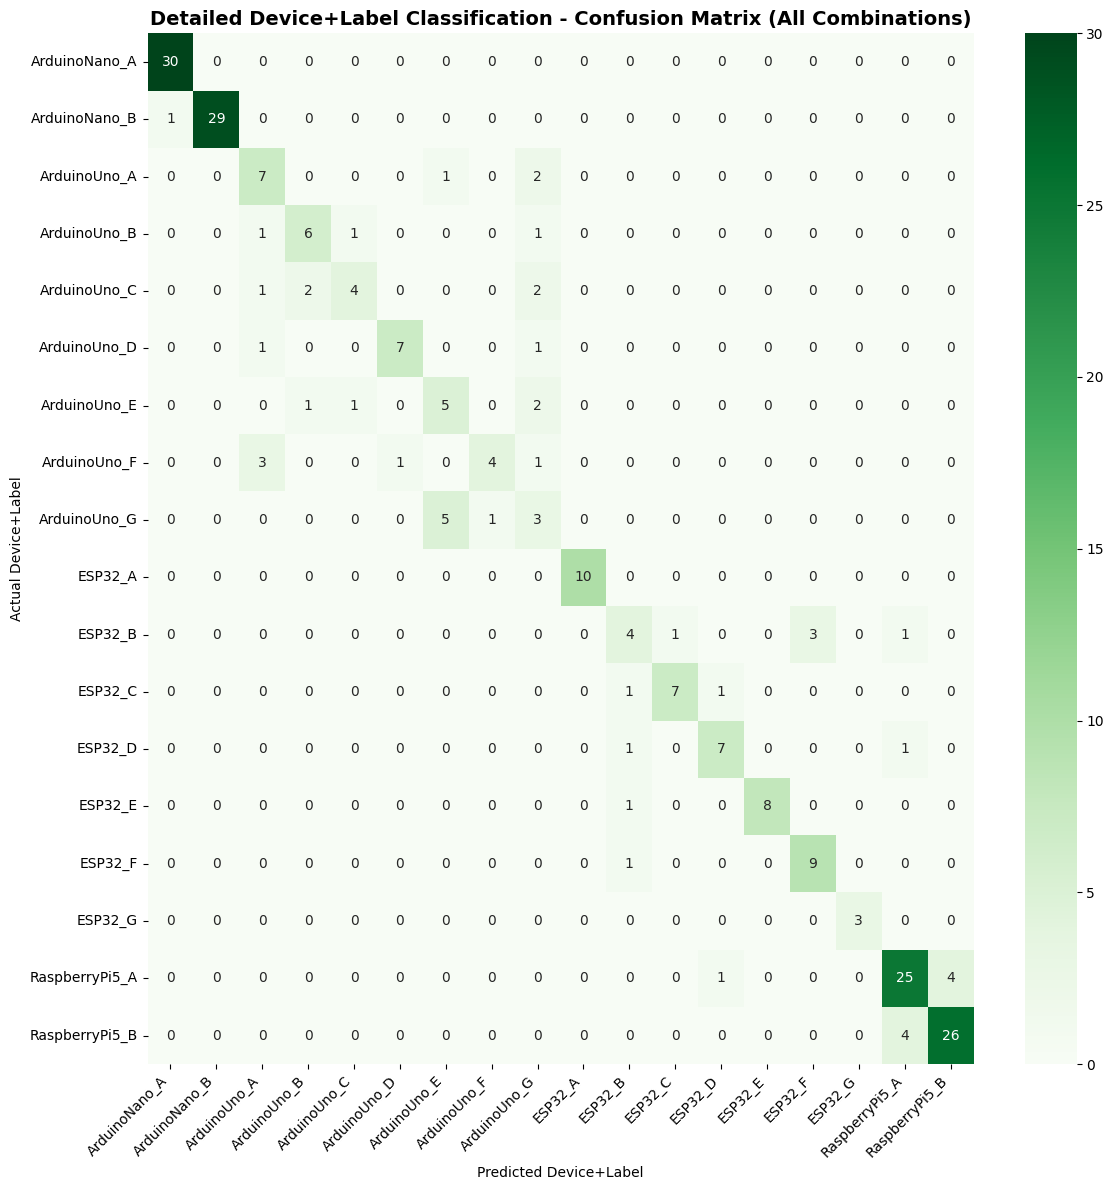


Detailed matrix shows 18 unique device+label combinations


In [ ]:
# ==============================
# STEP 6: DUAL CONFUSION MATRICES
# ==============================
def get_device_family(full_label):
    """Extract device family from full label"""
    for family in ['ArduinoUno', 'ArduinoNano', 'ESP32', 'RaspberryPi5']:
        if family in full_label:
            return family
    return full_label

# CONFUSION MATRIX 1: Device Families (4x4)
print("\n" + "="*50)
print("CONFUSION MATRIX 1: DEVICE FAMILIES")
print("="*50)

y_pred_family = [get_device_family(label) for label in y_pred_full_decoded]
y_val_family_decoded = [get_device_family(label) for label in y_val_full_decoded]

family_labels = ['ArduinoNano', 'ArduinoUno', 'ESP32', 'RaspberryPi5']
cm_family = confusion_matrix(y_val_family_decoded, y_pred_family, labels=family_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_family, annot=True, fmt='d', cmap='Blues',
            xticklabels=family_labels, yticklabels=family_labels)
plt.title('Device Family Classification - Confusion Matrix (4 Classes)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Device Family')
plt.ylabel('Actual Device Family')
plt.tight_layout()
plt.show()

# CONFUSION MATRIX 2: All Detailed Labels
print("\n" + "="*50)
print("CONFUSION MATRIX 2: ALL DETAILED LABELS")
print("="*50)

# Get all unique labels in the validation set
all_labels = sorted(set(y_val_full_decoded) | set(y_pred_full_decoded))
cm_detailed = confusion_matrix(y_val_full_decoded, y_pred_full_decoded, labels=all_labels)

# Create a larger figure for detailed matrix
fig_size = max(12, len(all_labels) * 0.6)
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(cm_detailed, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Detailed Device+Label Classification - Confusion Matrix (All Combinations)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Device+Label')
plt.ylabel('Actual Device+Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nDetailed matrix shows {len(all_labels)} unique device+label combinations")

In [ ]:
# ==============================
# STEP 7: UNIVERSAL PREDICTION CLASSIFIER
# ==============================
class SignalClassifier:
    def __init__(self, models, label_encoder_full, label_encoder_family, scaler, feature_cols):
        self.models = models
        self.label_encoder_full = label_encoder_full
        self.label_encoder_family = label_encoder_family
        self.scaler = scaler
        self.feature_cols = feature_cols

    def predict_from_csv(self, csv_path):
        """
        Predict device and label from ANY CSV file containing signal features.
        Works with any CSV that has the required feature columns.
        """
        try:
            # Load the CSV
            df = pd.read_csv(csv_path)
            print(f"Loaded CSV with shape: {df.shape}")

            # Extract features
            feature_data = df.copy()

            # Handle missing columns (fill with 0 if not present)
            for col in self.feature_cols:
                if col not in feature_data.columns:
                    feature_data[col] = 0

            X_input = feature_data[self.feature_cols]
            X_input = X_input.fillna(0)

            # Store the number of samples
            num_samples = len(X_input)

            # Scale features
            X_scaled = self.scaler.transform(X_input)

            # Get predictions from all models for all rows
            individual_predictions = {}
            row_predictions = []

            for name, model in self.models.items():
                # Predict for all rows
                preds_encoded = model.predict(X_scaled)
                # Majority vote for this model
                majority_vote = np.bincount(preds_encoded).argmax()
                pred_label = self.label_encoder_full.inverse_transform([majority_vote])[0]
                individual_predictions[name] = pred_label
                row_predictions.append(preds_encoded)

            # Ensemble prediction: majority vote across models
            all_model_preds = list(individual_predictions.values())
            ensemble_pred_full = max(set(all_model_preds), key=all_model_preds.count)
            confidence = (all_model_preds.count(ensemble_pred_full) / len(all_model_preds)) * 100

            # Extract device family
            ensemble_pred_family = get_device_family(ensemble_pred_full)

            return {
                'ensemble_prediction_full': ensemble_pred_full,
                'ensemble_prediction_family': ensemble_pred_family,
                'confidence': confidence,
                'individual_predictions': individual_predictions,
                'num_samples': num_samples # Add num_samples here
            }

        except Exception as e:
            return {'error': str(e)}

# Create classifier
signal_classifier = SignalClassifier(
    models=trained_models,
    label_encoder_full=le_full,
    label_encoder_family=le_family,
    scaler=scaler,
    feature_cols=feature_cols
)

print("\n" + "="*60)
print("UNIVERSAL SIGNAL CLASSIFIER READY!")
print("="*60)
print(f"Trained on {len(le_full.classes_)} detailed labels")
print(f"Device families: {', '.join(family_labels)}")
print(f"Using {len(feature_cols)} features")
print("\nYou can now predict from ANY CSV file with these features!")
print("="*60)


UNIVERSAL SIGNAL CLASSIFIER READY!
Trained on 18 detailed labels
Device families: ArduinoNano, ArduinoUno, ESP32, RaspberryPi5
Using 21 features

You can now predict from ANY CSV file with these features!


In [ ]:
# ==============================
# STEP 8: TEST ON VALIDATION FILES
# ==============================
print("\n" + "="*70)
print("TESTING CLASSIFIER ON KNOWN DEVICE FILES (FOR VALIDATION)")
print("="*70)

test_results = []

for device_name, protocols in file_map.items():
    for protocol, file_list in protocols.items():
        for test_file in file_list:
            print(f"\n{'='*70}")
            print(f"Testing: {device_name} ({protocol})")
            print(f"File: {test_file}")
            print('='*70)

            result = signal_classifier.predict_from_csv(test_file)

            if 'error' in result:
                print(f"ERROR: {result['error']}")
                test_results.append({
                    'actual': device_name,
                    'predicted': 'ERROR',
                    'correct': False,
                    'file': test_file.split('/')[-1]
                })
            else:
                actual_device = device_name
                predicted_family = result['ensemble_prediction_family']
                predicted_full = result['ensemble_prediction_full']
                is_correct = (actual_device == predicted_family)

                print(f"\n{'✓' if is_correct else '✗'} ACTUAL DEVICE: {actual_device}")
                print(f"{'✓' if is_correct else '✗'} PREDICTED DEVICE: {predicted_family}")
                print(f"  Full Prediction: {predicted_full}")
                print(f"  Confidence: {result['confidence']:.1f}%")

                print(f"\n  Individual Model Predictions:")
                for model, pred in result['individual_predictions'].items():
                    status = "✓" if get_device_family(pred) == actual_device else "✗"
                    print(f"    {model:20s}: {pred} {status}")

                test_results.append({
                    'actual': actual_device,
                    'predicted_family': predicted_family,
                    'predicted_full': predicted_full,
                    'correct': is_correct,
                    'confidence': result['confidence'],
                    'file': test_file.split('/')[-1]
                })


TESTING CLASSIFIER ON KNOWN DEVICE FILES (FOR VALIDATION)

Testing: ArduinoNano (UART)
File: /content/UTRGV-Capstone-2025/Data/Processed/Arduino_Nano_9600_dataset.csv
Loaded CSV with shape: (300, 23)

✓ ACTUAL DEVICE: ArduinoNano
✓ PREDICTED DEVICE: ArduinoNano
  Full Prediction: ArduinoNano_A
  Confidence: 60.0%

  Individual Model Predictions:
    RandomForest        : ArduinoNano_A ✓
    SVM                 : ArduinoNano_A ✓
    KNN                 : ArduinoNano_B ✓
    LogisticRegression  : ArduinoNano_A ✓
    XGBoost             : ArduinoNano_B ✓

Testing: ArduinoUno (UART)
File: /content/UTRGV-Capstone-2025/Data/Processed/Arduino_UNO_9600_dataset.csv
Loaded CSV with shape: (320, 23)

✓ ACTUAL DEVICE: ArduinoUno
✓ PREDICTED DEVICE: ArduinoUno
  Full Prediction: ArduinoUno_A
  Confidence: 80.0%

  Individual Model Predictions:
    RandomForest        : ArduinoUno_A ✓
    SVM                 : ArduinoUno_A ✓
    KNN                 : ArduinoUno_A ✓
    LogisticRegression  : Arduino

In [ ]:
# ==============================
# STEP 9: TESTING SUMMARY
# ==============================
print("\n" + "="*70)
print("TESTING SUMMARY")
print("="*70)

correct_predictions = sum(1 for r in test_results if r['correct'])
total_tests = len(test_results)
accuracy = (correct_predictions / total_tests) * 100 if total_tests > 0 else 0

print(f"\nOverall Device Family Accuracy: {accuracy:.1f}% ({correct_predictions}/{total_tests})")
print("\nDetailed Results:")
print(f"{'File':<40} {'Actual':<15} {'Predicted':<15} {'Full Label':<20} {'Confidence':<12} {'Result'}")
print("-" * 110)

for result in test_results:
    status = "✓ CORRECT" if result['correct'] else "✗ WRONG"
    predicted_full = result.get('predicted_full', 'ERROR')
    confidence = result.get('confidence', 0)
    print(f"{result['file']:<40} {result['actual']:<15} {result.get('predicted_family', 'ERROR'):<15} {predicted_full:<20} {confidence:>6.1f}%     {status}")

print("\n" + "="*70)



TESTING SUMMARY

Overall Device Family Accuracy: 100.0% (4/4)

Detailed Results:
File                                     Actual          Predicted       Full Label           Confidence   Result
--------------------------------------------------------------------------------------------------------------
Arduino_Nano_9600_dataset.csv            ArduinoNano     ArduinoNano     ArduinoNano_A          60.0%     ✓ CORRECT
Arduino_UNO_9600_dataset.csv             ArduinoUno      ArduinoUno      ArduinoUno_A           80.0%     ✓ CORRECT
ESP_32_9600_dataset.csv                  ESP32           ESP32           ESP32_F                60.0%     ✓ CORRECT
RPi_5B_9600_dataset.csv                  RaspberryPi5    RaspberryPi5    RaspberryPi5_A         60.0%     ✓ CORRECT



In [ ]:
# Load mixed data
df = pd.read_csv("Combined_Device_Data.csv")

# Prepare features
X_input = df[feature_cols].fillna(0)
X_scaled = scaler.transform(X_input)

# Get predictions from all models
model_preds = {name: model.predict(X_scaled) for name, model in trained_models.items()}

# Majority vote per row
final_predictions = []
for i in range(len(df)):
    votes = [model_preds[name][i] for name in trained_models]
    majority_vote = np.bincount(votes).argmax()
    final_predictions.append(le_full.inverse_transform([majority_vote])[0])

# Add predictions to dataframe
df['Predicted_Full'] = final_predictions
df['Predicted_Family'] = df['Predicted_Full'].apply(get_device_family)
df['Correct'] = df['Device_Family'] == df['Predicted_Family']


# ==============================
# ==============================
print("\n" + "="*80)
print("SAMPLED RESULTS (5 ROWS PER DEVICE TYPE)")
print("="*80)

grouped_sample = df.groupby('Device_Family').apply(
    lambda x: x.sample(5, random_state=42)
).reset_index(drop=True)

view_cols = ['Device_Family', 'Predicted_Family', 'Predicted_Full', 'Correct']
print(grouped_sample[view_cols].to_string(index=False))

print("\n" + "="*80)
print("INSPECTING THE ERRORS (WHERE MODEL FAILED)")
print("="*80)

errors = df[df['Correct'] == False]

if not errors.empty:
    print(f"Found {len(errors)} mismatches out of {len(df)} rows:")
    print("-" * 80)
    print(errors[view_cols].to_string(index=False))
else:
    print("Incredible! There were 0 errors in this random sample.")
print("="*80)


SAMPLED RESULTS (5 ROWS PER DEVICE TYPE)
Device_Family Predicted_Family Predicted_Full  Correct
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
  ArduinoNano      ArduinoNano  ArduinoNano_B     True
  ArduinoNano      ArduinoNano  ArduinoNano_B     True
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
  ArduinoNano      ArduinoNano  ArduinoNano_A     True
   ArduinoUno       ArduinoUno   ArduinoUno_C     True
   ArduinoUno       ArduinoUno   ArduinoUno_F     True
   ArduinoUno       ArduinoUno   ArduinoUno_F     True
   ArduinoUno       ArduinoUno   ArduinoUno_G     True
   ArduinoUno       ArduinoUno   ArduinoUno_A     True
        ESP32            ESP32        ESP32_E     True
        ESP32            ESP32        ESP32_A     True
        ESP32            ESP32        ESP32_D     True
        ESP32            ESP32        ESP32_C     True
        ESP32            ESP32        ESP32_B     True
 RaspberryPi5     RaspberryPi5 RaspberryPi5_B     True
 RaspberryPi5     Raspb

/tmp/ipython-input-3858914659.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_sample = df.groupby('Device_Family').apply(



TRAINING MESSAGE SIZE CLASSIFIER

Message size distribution:
msg_size_category
large     413
medium    402
small     396
Name: count, dtype: int64

Message size classes: ['large' 'medium' 'small']

Training message size classifier...
Training samples: 968
Validation samples: 243

MODEL-BY-MODEL MESSAGE SIZE PREDICTION RESULTS

Training RandomForest for message size...
RandomForest Accuracy: 1.0000 (100.00%)

RandomForest Classification Report:
              precision    recall  f1-score   support

       large       1.00      1.00      1.00        83
      medium       1.00      1.00      1.00        81
       small       1.00      1.00      1.00        79

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



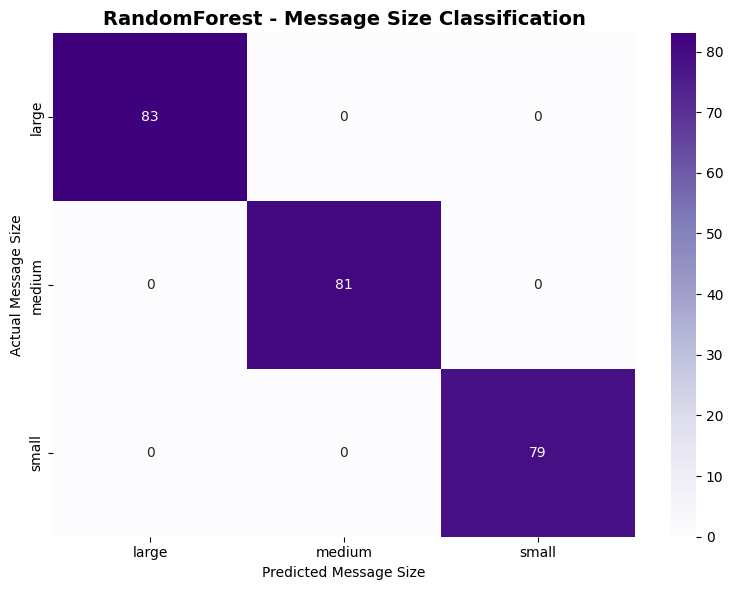


Training SVM for message size...
SVM Accuracy: 0.9877 (98.77%)

SVM Classification Report:
              precision    recall  f1-score   support

       large       1.00      1.00      1.00        83
      medium       1.00      0.96      0.98        81
       small       0.96      1.00      0.98        79

    accuracy                           0.99       243
   macro avg       0.99      0.99      0.99       243
weighted avg       0.99      0.99      0.99       243



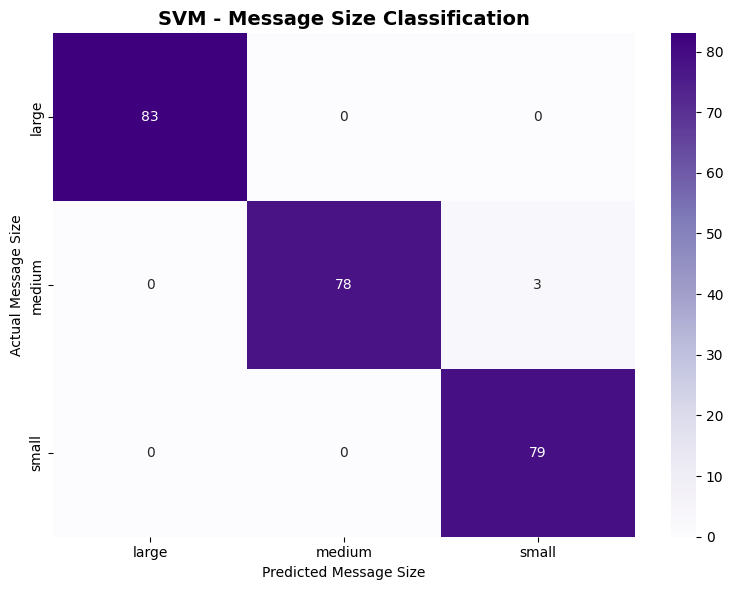


Training KNN for message size...
KNN Accuracy: 0.9671 (96.71%)

KNN Classification Report:
              precision    recall  f1-score   support

       large       0.99      1.00      0.99        83
      medium       0.93      0.98      0.95        81
       small       0.99      0.92      0.95        79

    accuracy                           0.97       243
   macro avg       0.97      0.97      0.97       243
weighted avg       0.97      0.97      0.97       243



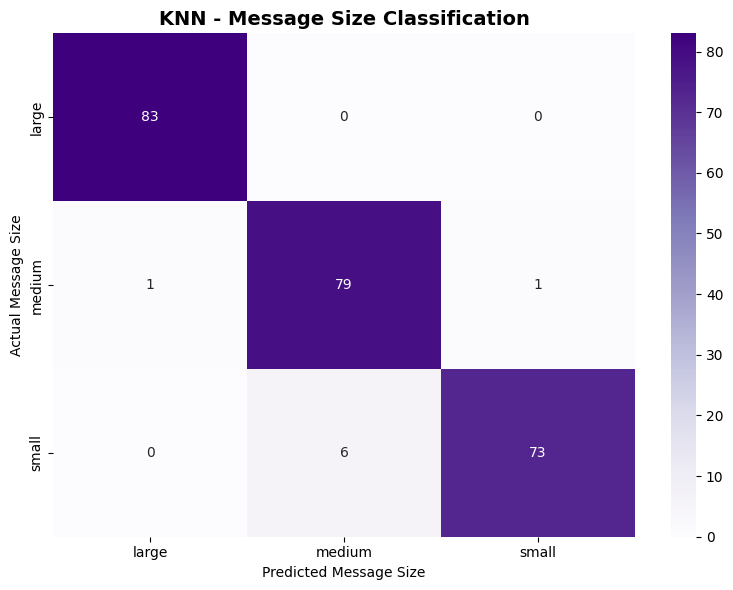


Training LogisticRegression for message size...
LogisticRegression Accuracy: 0.9959 (99.59%)

LogisticRegression Classification Report:
              precision    recall  f1-score   support

       large       1.00      1.00      1.00        83
      medium       1.00      0.99      0.99        81
       small       0.99      1.00      0.99        79

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



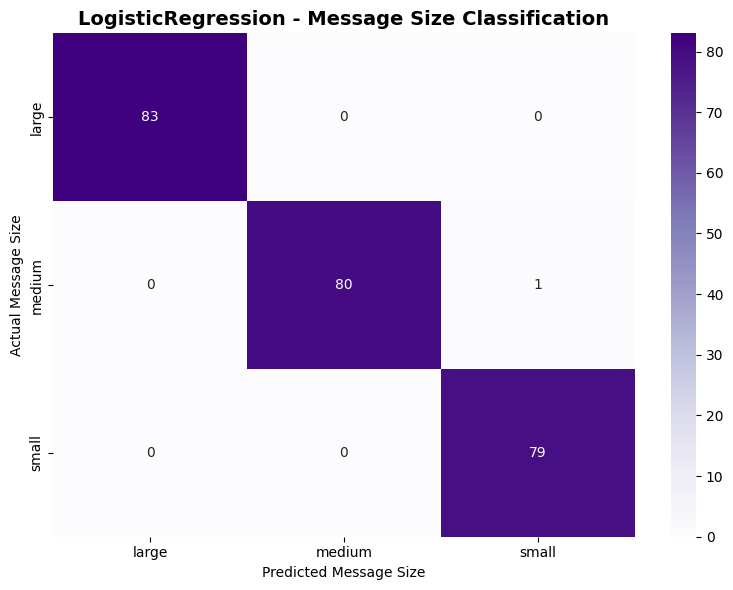


Training XGBoost for message size...
XGBoost Accuracy: 1.0000 (100.00%)

XGBoost Classification Report:
              precision    recall  f1-score   support

       large       1.00      1.00      1.00        83
      medium       1.00      1.00      1.00        81
       small       1.00      1.00      1.00        79

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



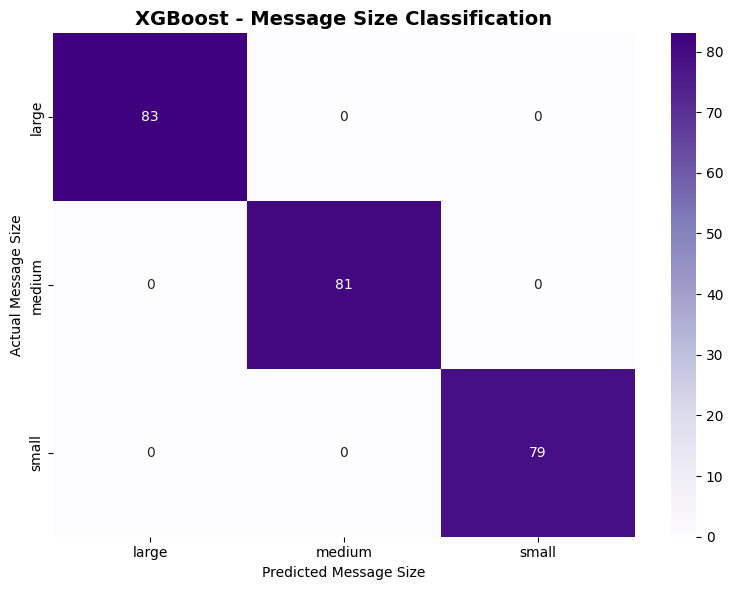


MESSAGE SIZE ACCURACY SUMMARY (ALL MODELS)
RandomForest             : 1.0000 (100.00%)
SVM                      : 0.9877 (98.77%)
KNN                      : 0.9671 (96.71%)
LogisticRegression       : 0.9959 (99.59%)
XGBoost                  : 1.0000 (100.00%)

COMBINED CLASSIFIER READY!
Can now predict:
  1. Device Family (ArduinoNano, ArduinoUno, ESP32, RaspberryPi5)
  2. Full Device Label
  3. Message Size per model (large, medium, small)


In [ ]:
# ==============================
# MESSAGE SIZE PREDICTION
# ==============================
print("\n" + "="*70)
print("TRAINING MESSAGE SIZE CLASSIFIER")
print("="*70)

# Check if msg_size column exists in combined_df
if 'msg_size' in combined_df.columns:
    # Create a copy with message size labels
    msg_df = combined_df.copy()

    # Map numeric msg_size to categories if needed
    # Assuming: 0=small, 1=medium, 2=large (adjust if different)
    size_mapping = {0: 'small', 1: 'medium', 2: 'large'}
    msg_df['msg_size_category'] = msg_df['msg_size'].map(size_mapping)

    # If msg_size is already categorical, use it directly
    if msg_df['msg_size'].dtype == 'object':
        msg_df['msg_size_category'] = msg_df['msg_size']

    print(f"\nMessage size distribution:")
    print(msg_df['msg_size_category'].value_counts())

    # Prepare features and target
    X_msg = msg_df[feature_cols].fillna(0)
    X_msg_scaled = scaler.transform(X_msg)

    # Encode message size labels
    le_msg_size = LabelEncoder()
    y_msg_size = le_msg_size.fit_transform(msg_df['msg_size_category'])

    print(f"\nMessage size classes: {le_msg_size.classes_}")

    # Train/test split
    X_train_msg, X_val_msg, y_train_msg, y_val_msg = train_test_split(
        X_msg_scaled, y_msg_size,
        test_size=0.2,
        stratify=y_msg_size,
        random_state=42
    )

    print(f"\nTraining message size classifier...")
    print(f"Training samples: {len(X_train_msg)}")
    print(f"Validation samples: {len(X_val_msg)}")

    # Train models for message size prediction
    msg_size_models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    msg_size_results = []
    trained_msg_size_models = {}

    print("\n" + "="*70)
    print("MODEL-BY-MODEL MESSAGE SIZE PREDICTION RESULTS")
    print("="*70)

    for name, model in msg_size_models.items():
        print(f"\n{'='*50}")
        print(f"Training {name} for message size...")
        print('='*50)
        model.fit(X_train_msg, y_train_msg)
        y_pred_msg = model.predict(X_val_msg)

        accuracy = np.mean(y_pred_msg == y_val_msg)
        msg_size_results.append((name, accuracy))
        trained_msg_size_models[name] = model

        print(f"{name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Decode predictions for this model
        y_pred_msg_decoded = le_msg_size.inverse_transform(y_pred_msg)
        y_val_msg_decoded = le_msg_size.inverse_transform(y_val_msg)

        # Classification report for this model
        print(f"\n{name} Classification Report:")
        print(classification_report(y_val_msg_decoded, y_pred_msg_decoded, zero_division=0))

        # Confusion matrix for this model
        cm_msg_size = confusion_matrix(y_val_msg_decoded, y_pred_msg_decoded,
                                        labels=le_msg_size.classes_)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_msg_size, annot=True, fmt='d', cmap='Purples',
                    xticklabels=le_msg_size.classes_,
                    yticklabels=le_msg_size.classes_)
        plt.title(f'{name} - Message Size Classification',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Message Size')
        plt.ylabel('Actual Message Size')
        plt.tight_layout()
        plt.show()

    # Summary of all models
    print("\n" + "="*70)
    print("MESSAGE SIZE ACCURACY SUMMARY (ALL MODELS)")
    print("="*70)
    for name, acc in msg_size_results:
        print(f"{name:25s}: {acc:.4f} ({acc*100:.2f}%)")

    # Add message size prediction to classifier (per model)
    class CombinedSignalClassifier(SignalClassifier):
        def __init__(self, device_models, msg_size_models,
                     label_encoder_full, label_encoder_family,
                     label_encoder_msg_size, scaler, feature_cols):
            super().__init__(device_models, label_encoder_full,
                           label_encoder_family, scaler, feature_cols)
            self.msg_size_models = msg_size_models
            self.label_encoder_msg_size = label_encoder_msg_size

        def predict_from_csv(self, csv_path):
            # Get device prediction (from parent class)
            device_result = super().predict_from_csv(csv_path)

            if 'error' in device_result:
                return device_result

            try:
                # Load CSV again for message size prediction
                df = pd.read_csv(csv_path)

                # Extract and scale features
                feature_data = df.copy()
                for col in self.feature_cols:
                    if col not in feature_data.columns:
                        feature_data[col] = 0

                X_input = feature_data[self.feature_cols].fillna(0)
                X_scaled = self.scaler.transform(X_input)

                # Predict message size with each model (no ensemble)
                msg_size_preds = {}
                for name, model in self.msg_size_models.items():
                    preds_encoded = model.predict(X_scaled)
                    # Majority vote per model across all samples
                    majority_vote = np.bincount(preds_encoded).argmax()
                    pred_label = self.label_encoder_msg_size.inverse_transform([majority_vote])[0]
                    msg_size_preds[name] = pred_label

                # Add message size predictions to result (per model, no ensemble)
                device_result['individual_msg_size_predictions'] = msg_size_preds

                return device_result

            except Exception as e:
                device_result['msg_size_error'] = str(e)
                return device_result

    # Create combined classifier
    combined_classifier = CombinedSignalClassifier(
        device_models=trained_models,
        msg_size_models=trained_msg_size_models,
        label_encoder_full=le_full,
        label_encoder_family=le_family,
        label_encoder_msg_size=le_msg_size,
        scaler=scaler,
        feature_cols=feature_cols
    )

    print("\n" + "="*70)
    print("COMBINED CLASSIFIER READY!")
    print("="*70)
    print("Can now predict:")
    print("  1. Device Family (ArduinoNano, ArduinoUno, ESP32, RaspberryPi5)")
    print("  2. Full Device Label")
    print(f"  3. Message Size per model ({', '.join(le_msg_size.classes_)})")
    print("="*70)

